## Visualisation of All Trained Models

This notebook is meant for you to be able to run all our pretrained models in the final_models folder and see the difference in performance.

In [19]:
# We first import all necessary libraries:

# Matplotlib
import requests
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Torch
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# MISC
import pandas as pd
from tqdm import tqdm
import os

In [20]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### We will define all of the different models and load them

#### 1.LSTM

In [21]:
class LSTM_pt(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM_pt, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        
        # LSTM layer
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        # # LayerNorm applied to the hidden state
        # self.layer_norm = torch.nn.LayerNorm(hidden_dim)

        # Fully connected layer
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x, h0=None, c0=None):
        if h0 is None or c0 is None:
            h0 = torch.randn(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
            c0 = torch.randn(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        
        # LSTM forward pass
        out, (hn, cn) = self.lstm(x, (h0, c0))

        # Apply LayerNorm to the output of the LSTM
        # out = self.layer_norm(out)

        # Pass only the last timestep's output to the FC layer
        out = self.fc(out[:, -1, :])  

        return out, hn, cn

In [22]:
# Load Model
import random

# Define the model parameters
input_size = 8
hidden_size = 128
num_layers = 1
output_size = 3
num_epochs = 300
learning_rate = 0.01

LSTM_model = LSTM_pt(input_size, hidden_size, num_layers, output_size).to(device)
model_path = './final_models/LSTM.pth'
if os.path.exists(model_path):
    LSTM_model.load_state_dict(torch.load(model_path, map_location=device))
    LSTM_model.eval() 
else:
    print(f"Model file not found at: {model_path}")

<All keys matched successfully>

#### 2.Bidirectional LSTM

In [23]:
class BiLSTM_pt(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(BiLSTM_pt, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.num_directions = 2  # Since it's bidirectional
        
        # LSTM layer
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)

        # Fully connected layer
        self.fc = torch.nn.Linear(hidden_dim * 2, output_dim)  # Fix here

    def forward(self, x, h0=None, c0=None):
        if h0 is None or c0 is None:
            h0 = torch.randn(self.layer_dim * self.num_directions, x.size(0), self.hidden_dim).to(x.device)
            c0 = torch.randn(self.layer_dim * self.num_directions, x.size(0), self.hidden_dim).to(x.device)

        # LSTM forward pass
        out, (hn, cn) = self.lstm(x, (h0, c0))

        # Pass only the last timestep's output to the FC layer
        out = self.fc(out[:, -1, :])  

        return out, hn, cn

In [24]:
# Define the model parameters
input_size = 8
hidden_size = 256
num_layers = 2 # Can be changed to stack multiple LSTM layers!
output_size = 3

Bi_LSTM_model = BiLSTM_pt(input_size, hidden_size, num_layers, output_size).to(device)
Bi_LSTM_model.load_state_dict(torch.load('./final_models/Bi_LSTM.pth'))

<All keys matched successfully>

#### 3.Encoder-Decoder LSTM

In [25]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size

        # print("Encoder's input size: ", input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

    def forward(self, inputs):
        # Passing the input sequence through the LSTM
        
        output, (hidden, cell) = self.lstm(inputs)
        # print("encoder output size: ", output.shape)

        return hidden, cell

In [26]:
class DecoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate=0.3):
        super(DecoderLSTM, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

        # Implementing Prof Idea
        self.linear1 = nn.Linear(hidden_size, 1)
        self.linearsub1 = nn.Linear(hidden_size, input_size)

        self.linear2 = nn.Linear(hidden_size, 1)
        self.linearsub2 = nn.Linear(hidden_size, input_size)

        self.linear3 = nn.Linear(hidden_size, 1)

        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x, hidden,target=None):
        outputs = []
        decoder_input = x
        
        # First LSTM layer
        y1, hidden1 = self.lstm(decoder_input, hidden)
        y1 = self.dropout(y1)
        linear_y1 = self.linear1(y1)
        linear_y1 = linear_y1.mean(dim=1, keepdim=True)
        linear_suby1 = self.linearsub1(y1)

        # Second LSTM layer
        y2, hidden2 = self.lstm(linear_suby1, hidden1)
        y2 = self.dropout(y2)
        linear_y2 = self.linear2(y2)
        linear_suby2 = self.linearsub1(y2)
        linear_y2 = linear_y2.mean(dim=1, keepdim=True)

        y3, hidden3 = self.lstm(linear_suby2, hidden2)
        y3 = self.dropout(y3)
        linear_y3 = self.linear3(y3)
        linear_y3 = linear_y3.mean(dim=1, keepdim=True)

        outputs.append(linear_y1.squeeze(1)) 
        outputs.append(linear_y2.squeeze(1))
        outputs.append(linear_y3.squeeze(1))

        final_output = torch.stack(outputs, dim=1)
        return final_output

In [27]:
class Seq2Seq(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_rate):
        super(Seq2Seq, self).__init__()
        self.output_length = output_size
        input_size = 8
        self.encoder = EncoderLSTM(input_size, hidden_size) 
        self.decoder = DecoderLSTM(input_size, hidden_size, dropout_rate)
        
    def forward(self, inputs, outputs=None):

        # Encode the input sequence
        hidden = self.encoder(inputs)  # Get encoded hidden state from the encoder

        # Initialize decoder input (usually last input value or a special token)
        decoder_input = inputs[:, -1:, :] 
        # Decode the sequence
        output = self.decoder(decoder_input, hidden, outputs)
        return output

In [28]:
hidden_size = 256
Bi_Directional_LSTM_model = Seq2Seq(hidden_size = hidden_size, \
                        output_size = 3, dropout_rate = 0).to(device)
Bi_Directional_LSTM_model.load_state_dict(torch.load('./final_models/ED_LSTM.pth'))

<All keys matched successfully>

#### 4.Bidirectional Encoder-Decoder LSTM

In [29]:
class BiEncoderLSTM(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(BiEncoderLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_directions = 2  # Since it's bidirectional
        
        # LSTM layer
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
    def forward(self, inputs):

        inputs = inputs.to(device)
        out, (hn, cn) = self.lstm(inputs)
        hn_dec = hn[0] + hn[1]
        cn_dec = cn[0] + cn[1]

        hn_dec = hn_dec.unsqueeze(0)
        cn_dec = cn_dec.unsqueeze(0)

        return hn_dec, cn_dec

In [30]:
class DecoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(DecoderLSTM, self).__init__()


        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

        # Implementing Prof Idea
        self.linear1 = nn.Linear(hidden_size, 1)
        self.linearsub1 = nn.Linear(hidden_size, input_size)

        self.linear2 = nn.Linear(hidden_size, 1)
        self.linearsub2 = nn.Linear(hidden_size, input_size)

        self.linear3 = nn.Linear(hidden_size, 1)

    def forward(self, x, hidden,):
        outputs = []
        decoder_input = x
        
        # First LSTM layer
        decoder_input = decoder_input.to(device)
        y1, hidden1 = self.lstm(decoder_input, hidden)
        linear_y1 = self.linear1(y1)
        linear_y1 = linear_y1.mean(dim=1, keepdim=True)
        linear_suby1 = self.linearsub1(y1)

        # Second LSTM layer
        y2, hidden2 = self.lstm(linear_suby1, hidden)
        linear_y2 = self.linear2(y2)
        linear_suby2 = self.linearsub2(y2)
        linear_y2 = linear_y2.mean(dim=1, keepdim=True)

        y3, hidden3 = self.lstm(linear_suby2, hidden)
        linear_y3 = self.linear3(y3)
        linear_y3 = linear_y3.mean(dim=1, keepdim=True)

        outputs.append(linear_y1.squeeze(1))  # shape: [17, 1]
        outputs.append(linear_y2.squeeze(1))
        outputs.append(linear_y3.squeeze(1))

        final_output = torch.stack(outputs, dim=1)  # [17, 3, 1]
        return final_output

In [31]:
class Seq2Seq(nn.Module):
    def __init__(self, hidden_size, output_size, input_size):
        super(Seq2Seq, self).__init__()
        self.output_length = output_size
        self.encoder = BiEncoderLSTM(input_size, hidden_size) 
        self.decoder = DecoderLSTM(input_size, hidden_size)
        
    def forward(self, inputs, outputs=None):

        # Encode the input sequence
        inputs = inputs.to(device)
        hidden = self.encoder(inputs)  # Get encoded hidden state from the encoder

        # Initialize decoder input (usually last input value or a special token)
        decoder_input = inputs
        # Decode the sequence
        output = self.decoder(decoder_input, hidden)
        return output

In [32]:
input_size = 8
hidden_size = 128
output_size = 3

# Initialize Seq2Seq Model
Bi_ED_LSTM_model = Seq2Seq(hidden_size = hidden_size, output_size = output_size, input_size=input_size).to(device)
Bi_ED_LSTM_model.load_state_dict(torch.load('./final_models/Bi-ED-LSTM.pth'))

<All keys matched successfully>

#### 5.Transformer

In [33]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, num_heads, num_layers, hidden_dim, dropout=0.1):
        super(TransformerModel, self).__init__()
        
        self.embedding = nn.Linear(input_size, hidden_dim)         # input_size = 3
        self.decoder_embedding = nn.Linear(1, hidden_dim)        
        self.encoder_positional_encoding = nn.Parameter(torch.rand(1, 100, hidden_dim)) 
        self.decoder_positional_encoding = nn.Parameter(torch.rand(1, 100, hidden_dim))  # max_seq_len=100


        self.transformer = nn.Transformer(
            d_model=hidden_dim, 
            nhead=num_heads, 
            num_encoder_layers=num_layers, 
            num_decoder_layers=num_layers, 
            dim_feedforward=hidden_dim * 2, 
            dropout=dropout,
            batch_first=True
        )

        self.fc_out = nn.Linear(hidden_dim, output_size)
    
    def forward(self, src, tgt=None):
        src = self.embedding(src)
        src += self.encoder_positional_encoding[:, :src.size(1), :]

        
        if tgt is not None:
            tgt_input = self.decoder_embedding(tgt)
            tgt_input += self.decoder_positional_encoding[:, :tgt_input.size(1), :]
        else:
            print("target is using source")
            tgt_input = src

        output = self.transformer(src, tgt_input)
        output = self.fc_out(output)
        return output

In [34]:
import random

input_size = 8
hidden_size = 64
num_layers = 1
output_size = 1
num_heads = 8

# Initialize Seq2Seq Model
transformer_model = TransformerModel(input_size, output_size, num_heads, num_layers, hidden_dim = hidden_size).to(device)
transformer_model.load_state_dict(torch.load('./final_models/transformer.pth'))
seed_value = random.randint(0, 10000)

#### 6. Ensemble (State of the art) : Random Forest + XGboost

In [26]:
import joblib
rf_model = joblib.load('./final_models/Ensemble_RF.pth')
xgb_model = joblib.load('./final_models/Ensemble_XGB.pth')
meta_model    = joblib.load('./final_models/Ensemble_Meta.pth')

## We then want to load in our test dataset

In [35]:
merged_weather_taxi_df = "merged_file_with_mean.csv"
taxi_df = pd.read_csv(merged_weather_taxi_df, delimiter = ",")

#Adjusting for weather parameters
taxi_df = taxi_df.drop(columns = "stationId")

#Adjusting for taxi_vailability parameters
taxi_df_coordinates = taxi_df["Coordinates[]"]
taxt_df_datetime = taxi_df["DateTime"]
taxi_df = taxi_df.drop(columns = "Coordinates[]")
taxi_df = taxi_df.drop(columns = "Taxi Available in Selected Box Area")
taxi_df["DateTime"] = pd.to_datetime(taxi_df["DateTime"])

taxi_df["IsWeekend"] = (taxi_df["DateTime"].dt.weekday >= 5).astype(int)
taxi_df["Hour"] = taxi_df["DateTime"].dt.hour + 1  # Convert 0-23 to 1-24
taxi_df = taxi_df.drop(columns = "DateTime")

# taxi_df=taxi_df[:5120]
numeric_columns = taxi_df.select_dtypes(include=['int64', 'int32','float64','object']).columns
taxi_df[numeric_columns] = taxi_df[numeric_columns].astype('float32')
numeric_columns = taxi_df.select_dtypes(include=['int64', 'int32','float64','object']).columns

# Convert selected columns to float32
taxi_df[numeric_columns] = taxi_df[numeric_columns].astype('float32')

# #---------------Normalise-----------------------
# Drop 'DateTime' as it's no longer needed
# Normalize the 'Hour' and 'IsWeekend' columns (if needed)

data_min = taxi_df.min(axis=0)
data_max = taxi_df.max(axis=0)
taxi_df_normalized = (taxi_df - data_min) / (data_max - data_min)

taxi_df_output_normalized  = taxi_df_normalized["Average Taxi Availability"]
taxi_df_output_training_normalized = taxi_df_normalized["Average Taxi Availability"]

taxi_df_normalized.to_csv("checker.csv", index=False)  # Set index=False to exclude row numbers

# Convert to NumPy arrays
input_data = taxi_df_normalized.values  # Shape: (5120, num_features)
output_data = taxi_df_output_normalized.values  # Shape: (5120,)
output_training_data = taxi_df_output_training_normalized.values

seq_length = 24
pred_horizon = 3  # Number of future time steps to predict

def create_sequences(data, labels, seq_length, pred_horizon):
    xs, ys = [], []
    for i in range(0, len(data), seq_length):  # Start from 0 and increment by seq_length
        if i + seq_length + pred_horizon <= len(data):  # Ensure enough data for prediction horizon
            xs.append(data[i:i + seq_length])  # Input sequence (continuous)
            ys.append(labels[i + seq_length : i + seq_length + pred_horizon])  # Next 3 values
    return np.array(xs), np.array(ys)

X, y = create_sequences(input_data, output_data, seq_length,pred_horizon)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y[:, None], dtype=torch.float32)
y = y.permute(0, 2, 1)  # Shape: (samples, pred_horizon, 1)

# Split sizes
total_samples = len(X)
train_size = int(0.8 * total_samples)
val_size = int(0.1 * total_samples)
test_size = total_samples - train_size - val_size

# Split the data
trainX, valX, testX = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
trainY, valY, testY = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

# Create TensorDatasets
train_dataset = TensorDataset(trainX, trainY)
val_dataset = TensorDataset(valX, valY)
test_dataset = TensorDataset(testX, testY)

# DataLoaders
batch_size = 17
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

print(taxi_df_normalized.head())


   Taxi Available throughout SG  temp_value  humidity_value  rainfall_value  \
0                      0.512628    0.801775        0.853807             0.0   
1                      0.602633    0.807692        0.837563             0.0   
2                      0.640516    0.810651        0.824365             0.0   
3                      0.714938    0.813609        0.831472             0.0   
4                      0.650457    0.819527        0.791878             0.0   

   peak_period  Average Taxi Availability  IsWeekend      Hour  
0          1.0                   0.417601        0.0  1.000000  
1          1.0                   0.371730        0.0  0.956522  
2          1.0                   0.410466        0.0  0.913043  
3          1.0                   0.407407        0.0  0.869565  
4          1.0                   0.347604        0.0  0.826087  


In [28]:
# Ensemble Model Data Preparation

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load data
ensemble_df = pd.read_csv("merged_file_with_mean.csv")

# Feature engineering
ensemble_df["DateTime"] = pd.to_datetime(ensemble_df["DateTime"])
ensemble_df["IsWeekend"] = (ensemble_df["DateTime"].dt.weekday >= 5).astype(int)
ensemble_df["Hour"] = ensemble_df["DateTime"].dt.hour + 1
ensemble_df["DayOfWeek"] = ensemble_df["DateTime"].dt.dayofweek

# Drop unused columns
ensemble_df = ensemble_df.drop(columns=["DateTime", "stationId", "Coordinates[]"])

# Add lag features
lag_features = ["Average Taxi Availability", "Taxi Available throughout SG", "temp_value", "humidity_value"]
for lag in range(1, 4):
    for col in lag_features:
        ensemble_df[f"{col}_lag{lag}"] = ensemble_df[col].shift(lag)

# Create multi-step ahead targets
ensemble_df["target_t1"] = ensemble_df["Average Taxi Availability"].shift(-1)
ensemble_df["target_t2"] = ensemble_df["Average Taxi Availability"].shift(-2)
ensemble_df["target_t3"] = ensemble_df["Average Taxi Availability"].shift(-3)

# Drop rows with NaNs from shift
ensemble_df = ensemble_df.dropna().reset_index(drop=True)

# Separate features and targets
target_cols = ["target_t1", "target_t2", "target_t3"]
X_ens = ensemble_df.drop(columns=target_cols).values
y_ens = ensemble_df[target_cols].values

# Normalize features
scaler_ens = MinMaxScaler()
X_ens_scaled = scaler_ens.fit_transform(X_ens)

# Train-test-validation split
X_train_ens, X_temp_ens, y_train_ens, y_temp_ens = train_test_split(X_ens_scaled, y_ens, test_size=0.2, random_state=23)
X_val_ens, X_test_ens, y_val_ens, y_test_ens = train_test_split(X_temp_ens, y_temp_ens, test_size=0.5, random_state=23)

# Wrap in DataFrames for visualization
feature_cols_ens = ensemble_df.drop(columns=target_cols).columns.tolist()
X_train_ens_df = pd.DataFrame(X_train_ens, columns=feature_cols_ens)
y_train_ens_df = pd.DataFrame(y_train_ens, columns=target_cols)

# Diagnostics
print("Ensemble Model Input Shape:", X_ens.shape)
print("Ensemble Target Shape:", y_ens.shape)

print(X_train_ens_df.head())
print(y_train_ens_df.head())


Ensemble Model Input Shape: (25585, 22)
Ensemble Target Shape: (25585, 3)
   Taxi Available throughout SG  Taxi Available in Selected Box Area  \
0                      0.447609                             0.281369   
1                      0.250134                             0.224335   
2                      0.508866                             0.368821   
3                      0.482805                             0.307985   
4                      0.518538                             0.425856   

   temp_value  humidity_value  rainfall_value  peak_period  \
0    0.842085        0.798758             0.0          0.0   
1    0.842085        0.798758             0.0          0.0   
2    0.872781        0.848731             0.0          0.0   
3    0.842085        0.798758             0.0          0.0   
4    0.842085        0.798758             0.0          0.0   

   Average Taxi Availability  IsWeekend      Hour  DayOfWeek  ...  \
0                   0.303772        1.0  0.000000  

## Display MAE and Graphs from all 6 models

#### 1.LSTM

Average Validation Loss: 0.0100
Mean Absolute Error: 17.3645


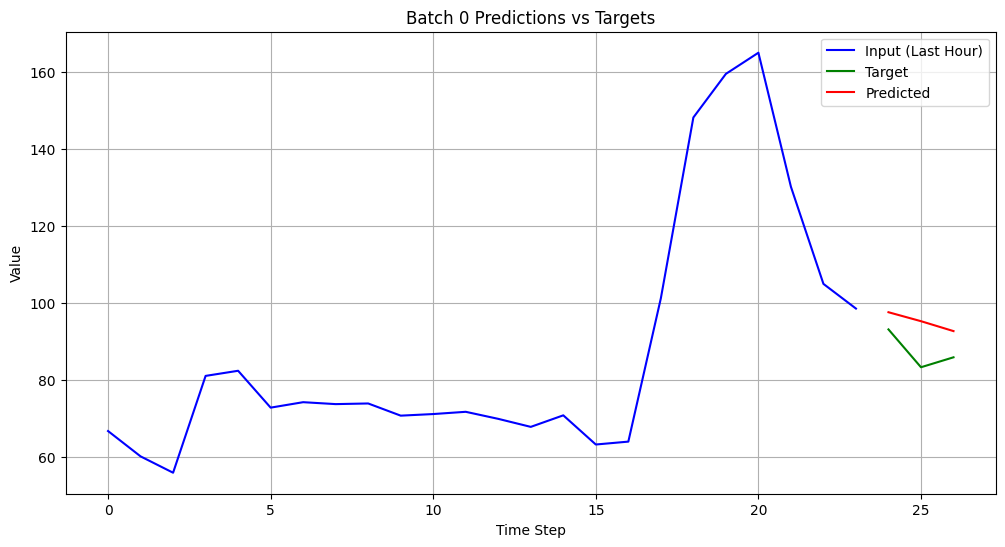

In [36]:
import collections
LSTM_model.eval()

# Initialize variables to track loss
loss_value = 0
num_batches = 0

# Define the loss function
criterion = torch.nn.MSELoss()

# Initialize hidden state and cell state
hidden_state, cell_state = None, None  
mae_list = []
visualise_dataset = collections.defaultdict(list)

# Disable gradient computation for validation
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
 
        # Forward pass
        inputs, cell_state, hidden_state = inputs.to(device), cell_state, hidden_state
        output, cell_state, hidden_state = LSTM_model(inputs, cell_state, hidden_state)
        output = output.unsqueeze(-1)

        output, targets = output.to(device), targets.to(device)

        # Denormalize predictions and targets (for all 3 time steps)
        inputs_denorm = inputs * (data_max["Average Taxi Availability"] - data_min["Average Taxi Availability"]) + data_min["Average Taxi Availability"]
        output_denorm = output * (data_max["Average Taxi Availability"] - data_min["Average Taxi Availability"]) + data_min["Average Taxi Availability"]
        targets_denorm = targets * (data_max["Average Taxi Availability"] - data_min["Average Taxi Availability"]) + data_min["Average Taxi Availability"]
        
        visualise_dataset[batch_idx] = inputs_denorm[:,:, 5:6].cpu().numpy()
        # Add targets to visualise_dataset
        visualise_dataset[batch_idx] = np.concatenate((visualise_dataset[batch_idx], targets_denorm.cpu().numpy()), axis=1)
        visualise_dataset[batch_idx] = np.concatenate((visualise_dataset[batch_idx], output_denorm.cpu().numpy()), axis=1)

        # Compute loss on normalized data
        loss_value += criterion(output, targets)
        mae = torch.mean(torch.abs(output_denorm - targets_denorm))
        mae_list.append(mae)

# Compute average loss
loss_value = loss_value / (len(test_loader) - 1)
print(f'Average Validation Loss: {loss_value:.4f}')

mae = torch.mean(torch.tensor(mae_list))
print(f'Mean Absolute Error: {mae:.4f}')

# Visualize the predictions and targets for the first batch
for batch_idx, data in visualise_dataset.items():
    inputs = data[0, :24]       # First 25 timesteps
    targets = data[0, 24:27]    # 3 timesteps: ground truth
    predictions = data[0, 27:]  # 3 timesteps: model predictions
    plt.figure(figsize=(12, 6))
    # Input: plotted from timestep 0 to 24
    plt.plot(range(24), inputs[:, -1], label='Input (Last Hour)', color='blue')
    # Targets: plotted starting from timestep 24 to 26
    plt.plot(range(24, 27), targets[:, -1], label='Target', color='green')
    # Predictions: plotted from timestep 27 to 29
    plt.plot(range(24, 27), predictions[:, -1], label='Predicted', color='red')
    plt.title(f'Batch {batch_idx} Predictions vs Targets')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()
    break

#### 2.Bidirectional LSTM

Average Validation Loss: 0.0114
Mean Absolute Error: 19.3650


c:\Users\littl\OneDrive\Documents\SUTD\Term 8\50.055 Special Topic Machine Learning Operations\Lecture\DL_Project\venv\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([17, 3, 1])) that is different to the input size (torch.Size([17, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


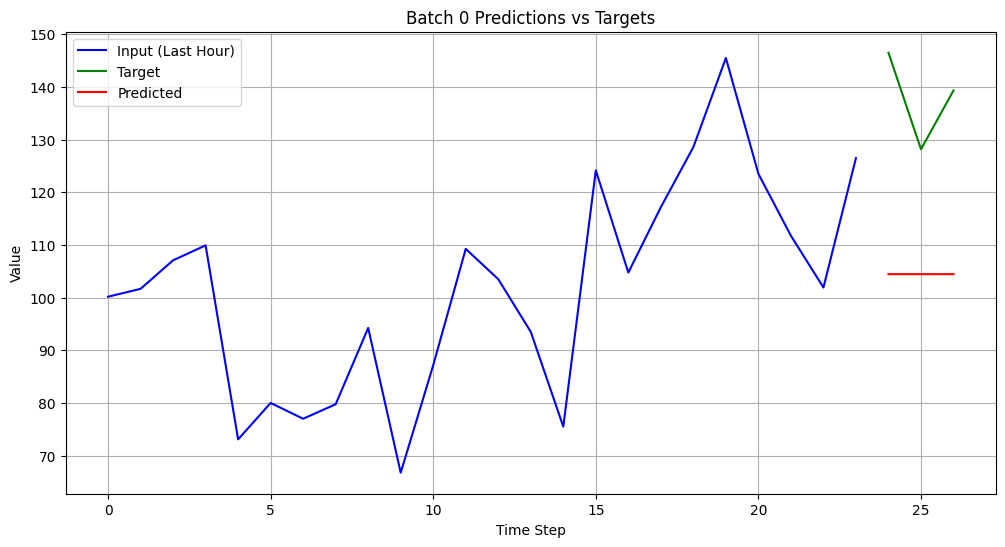

In [37]:
import collections

Bi_LSTM_model.eval()

# Initialize variables to track loss
loss_value = 0
num_batches = 0

# Define the loss function
criterion = torch.nn.MSELoss()

# Initialize hidden state and cell state
hidden_state, cell_state = None, None  
mae_list = []
visualise_dataset = collections.defaultdict(list)

# Disable gradient computation for validation
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):

        # Forward pass
        inputs = inputs.to(device)
        output, cell_state, hidden_state = Bi_LSTM_model(inputs, cell_state, hidden_state)
        output = output.unsqueeze(-1).permute(0, 2, 1)

        output = output.to(device)
        targets = targets.to(device)

        # Denormalize predictions and targets (for all 3 time steps)
        inputs_denorm = inputs * (data_max["Average Taxi Availability"] - data_min["Average Taxi Availability"]) + data_min["Average Taxi Availability"]
        output_denorm = output * (data_max["Average Taxi Availability"] - data_min["Average Taxi Availability"]) + data_min["Average Taxi Availability"]
        targets_denorm = targets * (data_max["Average Taxi Availability"] - data_min["Average Taxi Availability"]) + data_min["Average Taxi Availability"]

        flat_output = output_denorm.view(-1).tolist()
        result = [[[v] for v in inner[0]] for inner in output_denorm.tolist()]
        
        visualise_dataset[batch_idx] = inputs_denorm[:,:, 5:6].cpu().numpy()
        # Add targets to visualise_dataset
        visualise_dataset[batch_idx] = np.concatenate((visualise_dataset[batch_idx], targets_denorm.cpu().numpy()), axis=1)
        visualise_dataset[batch_idx] = np.concatenate((visualise_dataset[batch_idx], result), axis=1)
        
        # Compute loss on normalized data
        loss_value += criterion(output, targets)
        mae = torch.mean(torch.abs(torch.tensor(result).to(device) - targets_denorm))
        mae_list.append(mae)

# Compute average loss
loss_value = loss_value / (len(test_loader) - 1)
print(f'Average Validation Loss: {loss_value:.4f}')

mae = torch.mean(torch.tensor(mae_list))
print(f'Mean Absolute Error: {mae:.4f}')

# Visualize the predictions and targets for the first batch
for batch_idx, data in visualise_dataset.items():
    inputs = data[0, :24]       # First 25 timesteps
    targets = data[0, 24:27]    # 3 timesteps: ground truth
    predictions = data[0, 27:]  # 3 timesteps: model predictions
    plt.figure(figsize=(12, 6))
    # Input: plotted from timestep 0 to 24
    plt.plot(range(24), inputs[:, -1], label='Input (Last Hour)', color='blue')
    # Targets: plotted starting from timestep 24 to 26
    plt.plot(range(24, 27), targets[:, -1], label='Target', color='green')
    # Predictions: plotted from timestep 27 to 29
    plt.plot(range(24, 27), predictions[:, -1], label='Predicted', color='red')
    plt.title(f'Batch {batch_idx} Predictions vs Targets')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()
    break

#### 3.Encoder-Decoder LSTM

Average Validation Loss: 0.1654
Mean Absolute Error: 85.5288


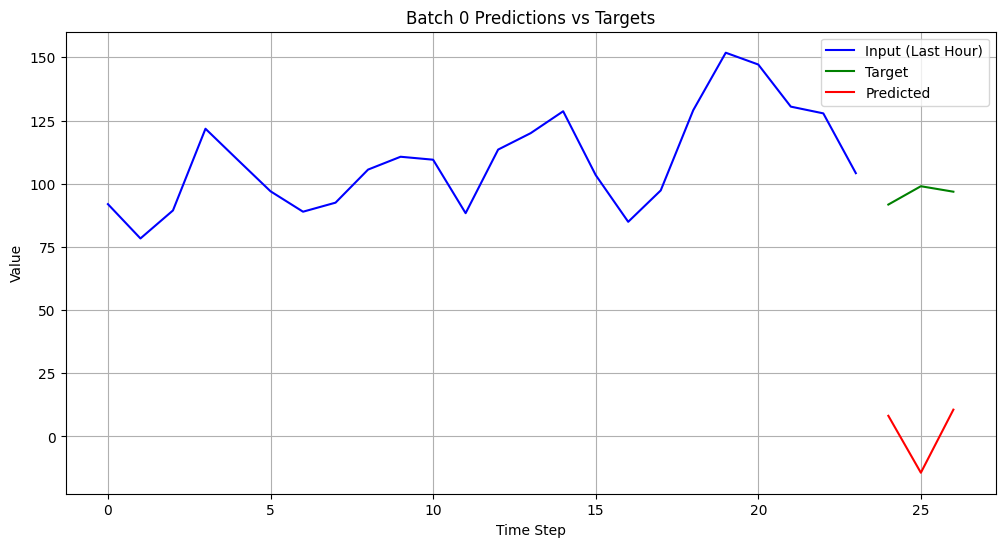

In [38]:
import collections

# Set the model to evaluation mode
Bi_Directional_LSTM_model.eval()

# Initialize variables to track loss
loss_value = 0
num_batches = 0

# Define the loss function
criterion = torch.nn.MSELoss()
mae_list = []
visualise_dataset = collections.defaultdict(list)

# Disable gradient computation for validation
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):

        # Forward pass (ensure correct hidden states are passed)
        inputs = inputs.to(device)  # Move inputs to GPU if available
        hidden_state, cell_state = Bi_Directional_LSTM_model.encoder(inputs)  # Get encoder hidden states
        decoder_input = inputs  # Use the input as the initial decoder input (you could also use a special token)

        # The decoder will use these hidden states
        output = Bi_Directional_LSTM_model.decoder(decoder_input, (hidden_state, cell_state))  # Pass hidden and cell states to the decoder

        output = output.to(device)  # Move output to GPU if available
        targets = targets.to(device)

        # Denormalize predictions and targets (for all 3 time steps)
        inputs_denorm = inputs * (data_max["Average Taxi Availability"] - data_min["Average Taxi Availability"]) + data_min["Average Taxi Availability"]
        output_denorm = output * (data_max["Average Taxi Availability"] - data_min["Average Taxi Availability"]) + data_min["Average Taxi Availability"]
        targets_denorm = targets * (data_max["Average Taxi Availability"] - data_min["Average Taxi Availability"]) + data_min["Average Taxi Availability"]
        
        visualise_dataset[batch_idx] = inputs_denorm[:,:, 5:6].cpu().numpy()
        # Add targets to visualise_dataset
        visualise_dataset[batch_idx] = np.concatenate((visualise_dataset[batch_idx], targets_denorm.cpu().numpy()), axis=1)
        visualise_dataset[batch_idx] = np.concatenate((visualise_dataset[batch_idx], output_denorm.cpu().numpy()), axis=1)

        # Compute loss on normalized data
        loss_value += criterion(output, targets)
        mae = torch.mean(torch.abs(output_denorm - targets_denorm))
        mae_list.append(mae)

# Compute average loss
loss_value = loss_value / (len(test_loader) - 1)
print(f'Average Validation Loss: {loss_value:.4f}')

mae = torch.mean(torch.tensor(mae_list))
print(f'Mean Absolute Error: {mae:.4f}')

# Visualize the predictions and targets for the first batch
for batch_idx, data in visualise_dataset.items():
    inputs = data[0, :24]       # First 25 timesteps
    targets = data[0, 24:27]    # 3 timesteps: ground truth
    predictions = data[0, 27:]  # 3 timesteps: model predictions
    plt.figure(figsize=(12, 6))
    # Input: plotted from timestep 0 to 24
    plt.plot(range(24), inputs[:, -1], label='Input (Last Hour)', color='blue')
    # Targets: plotted starting from timestep 24 to 26
    plt.plot(range(24, 27), targets[:, -1], label='Target', color='green')
    # Predictions: plotted from timestep 27 to 29
    plt.plot(range(24, 27), predictions[:, -1], label='Predicted', color='red')
    plt.title(f'Batch {batch_idx} Predictions vs Targets')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()
    break

#### 4.Bidirectional Encoder-Decoder LSTM

Average Validation Loss: 0.0078
Mean Absolute Error: 15.5402


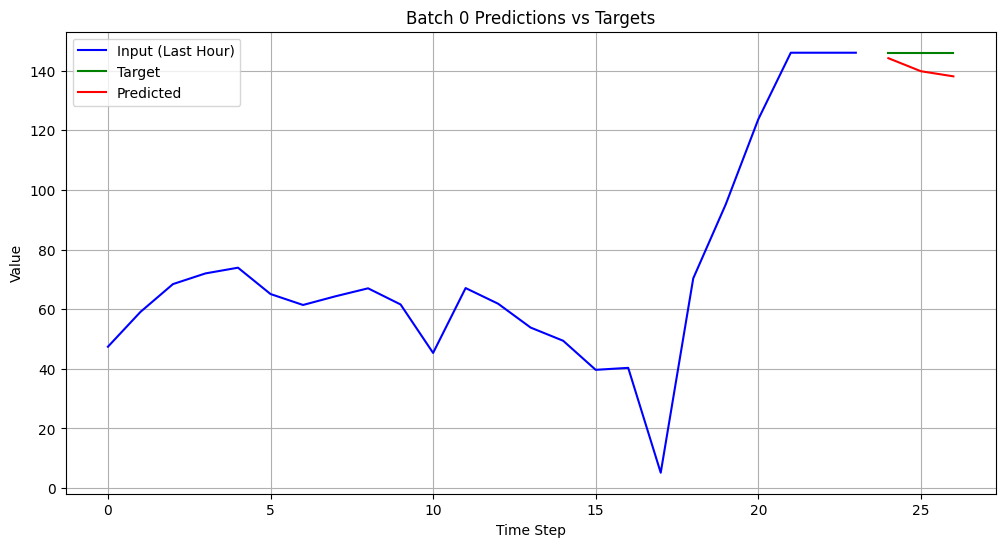

In [39]:
import collections

# Set the model to evaluation mode
Bi_ED_LSTM_model.eval()

# Initialize variables to track loss
loss_value = 0
num_batches = 0

# Define the loss function
criterion = torch.nn.MSELoss()
mae_list = []
visualise_dataset = collections.defaultdict(list)

# Disable gradient computation for validation
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):

        # Forward pass (ensure correct hidden states are passed)
        hidden_state, cell_state = Bi_ED_LSTM_model.encoder(inputs)  # Get encoder hidden states
        decoder_input = inputs  # Use the input as the initial decoder input (you could also use a special token)

        # The decoder will use these hidden states
        output = Bi_ED_LSTM_model.decoder(decoder_input, (hidden_state, cell_state))  # Pass hidden and cell states to the decoder

        # Denormalize predictions and targets (for all 3 time steps)
        output = output.to(device)
        targets = targets.to(device)
        inputs_denorm = inputs * (data_max["Average Taxi Availability"] - data_min["Average Taxi Availability"]) + data_min["Average Taxi Availability"]
        output_denorm = output * (data_max["Average Taxi Availability"] - data_min["Average Taxi Availability"]) + data_min["Average Taxi Availability"]
        targets_denorm = targets * (data_max["Average Taxi Availability"] - data_min["Average Taxi Availability"]) + data_min["Average Taxi Availability"]
        
        visualise_dataset[batch_idx] = inputs_denorm[:,:, 5:6].cpu().numpy()
        # Add targets to visualise_dataset
        visualise_dataset[batch_idx] = np.concatenate((visualise_dataset[batch_idx], targets_denorm.cpu().numpy()), axis=1)
        visualise_dataset[batch_idx] = np.concatenate((visualise_dataset[batch_idx], output_denorm.cpu().numpy()), axis=1)

        # Compute loss on normalized data
        loss_value += criterion(output, targets)
        mae = torch.mean(torch.abs(output_denorm - targets_denorm))
        mae_list.append(mae)

# Compute average loss
loss_value = loss_value / (len(test_loader) - 1)
print(f'Average Validation Loss: {loss_value:.4f}')

mae = torch.mean(torch.tensor(mae_list))
print(f'Mean Absolute Error: {mae:.4f}')

# Visualize the predictions and targets for the first batch
for batch_idx, data in visualise_dataset.items():
    inputs = data[0, :24]       # First 25 timesteps
    targets = data[0, 24:27]    # 3 timesteps: ground truth
    predictions = data[0, 27:]  # 3 timesteps: model predictions
    plt.figure(figsize=(12, 6))
    # Input: plotted from timestep 0 to 24
    plt.plot(range(24), inputs[:, -1], label='Input (Last Hour)', color='blue')
    # Targets: plotted starting from timestep 24 to 26
    plt.plot(range(24, 27), targets[:, -1], label='Target', color='green')
    # Predictions: plotted from timestep 27 to 29
    plt.plot(range(24, 27), predictions[:, -1], label='Predicted', color='red')
    plt.title(f'Batch {batch_idx} Predictions vs Targets')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()
    break

#### 5.Transformer

Average Validation Loss: 0.0096
Mean Absolute Error: 16.6095


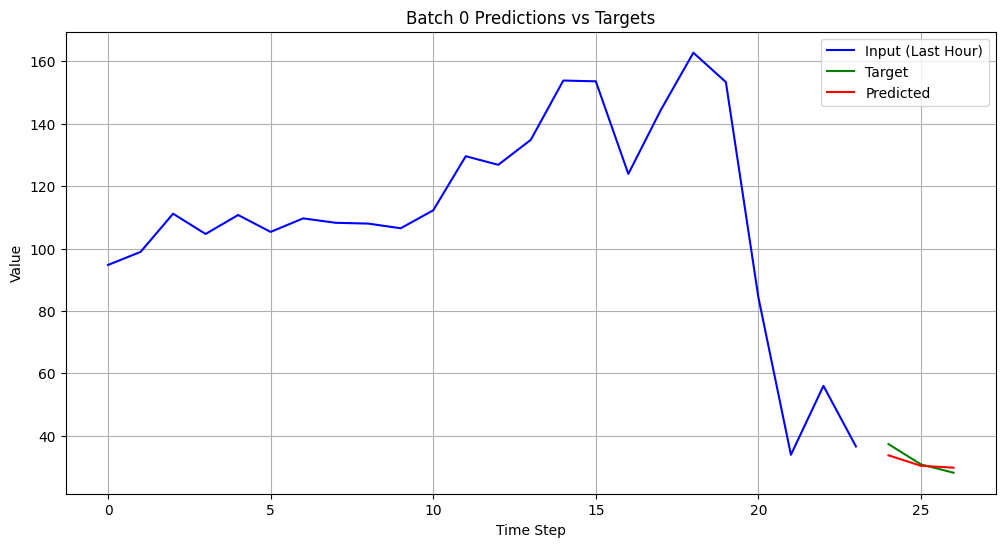

In [40]:
import collections
transformer_model.eval()  # Set the model to evaluation mode

# Initialize variables to track loss
loss_value = 0
num_batches = 0

# Define the loss function
criterion = torch.nn.MSELoss()
mae_list = []
visualise_dataset = collections.defaultdict(list)

# Disable gradient computation for validation
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):

        # Move data to device
        inputs, targets = inputs.to(device), targets.to(device)  # inputs: [B, 24, 7], targets: [B, 3, 1]

        # Initialize decoder input with a fixed token, e.g., 0.0
        batch_size = inputs.size(0)
        tgt_input = inputs[:, -1:, 5:6]  # Feed in last input as first output

        # Autoregressive prediction
        for step in range(targets.size(1)):  # Predict 3 steps
            output = transformer_model(inputs, tgt=tgt_input)  # output: [B, current_step+1, 1]
            next_token = output[:, -1:, :]  # [B, 1, 1]
            tgt_input = torch.cat([tgt_input, next_token], dim=1)  # Grow decoder input

        # Skip the first token (initial start token)
        predicted = tgt_input[:, 1:, :]  # [B, 3, 1]

        # Denormalize predictions and targets
        inputs_denorm = inputs * (data_max["Average Taxi Availability"] - data_min["Average Taxi Availability"]) + data_min["Average Taxi Availability"]
        output_denorm = predicted * (data_max["Average Taxi Availability"] - data_min["Average Taxi Availability"]) + data_min["Average Taxi Availability"]
        targets_denorm = targets * (data_max["Average Taxi Availability"] - data_min["Average Taxi Availability"]) + data_min["Average Taxi Availability"]
        
        visualise_dataset[batch_idx] = inputs_denorm[:,:, 5:6].cpu().numpy()
        # Add targets to visualise_dataset
        visualise_dataset[batch_idx] = np.concatenate((visualise_dataset[batch_idx], targets_denorm.cpu().numpy()), axis=1)
        visualise_dataset[batch_idx] = np.concatenate((visualise_dataset[batch_idx], output_denorm.cpu().numpy()), axis=1)

        # Compute loss on normalized data
        loss_value += criterion(output, targets)
        mae = torch.mean(torch.abs(output_denorm - targets_denorm))
        mae_list.append(mae)

# Compute average loss
loss_value = loss_value / (len(test_loader) - 1)
print(f'Average Validation Loss: {loss_value:.4f}')

mae = torch.mean(torch.tensor(mae_list))
print(f'Mean Absolute Error: {mae:.4f}')

# Visualize the predictions and targets for the first batch
for batch_idx, data in visualise_dataset.items():
    inputs = data[0, :24]       # First 25 timesteps
    targets = data[0, 24:27]    # 3 timesteps: ground truth
    predictions = data[0, 27:]  # 3 timesteps: model predictions
    plt.figure(figsize=(12, 6))
    # Input: plotted from timestep 0 to 24
    plt.plot(range(24), inputs[:, -1], label='Input (Last Hour)', color='blue')
    # Targets: plotted starting from timestep 24 to 26
    plt.plot(range(24, 27), targets[:, -1], label='Target', color='green')
    # Predictions: plotted from timestep 27 to 29
    plt.plot(range(24, 27), predictions[:, -1], label='Predicted', color='red')
    plt.title(f'Batch {batch_idx} Predictions vs Targets')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()
    break

#### 6. Ensemble (State of the art) : Random Forest + XGboost

Average Ensemble MAE (all steps): 10.4479
  ➤ Step t+1 MAE: 8.4805
  ➤ Step t+2 MAE: 10.9963
  ➤ Step t+3 MAE: 11.8669


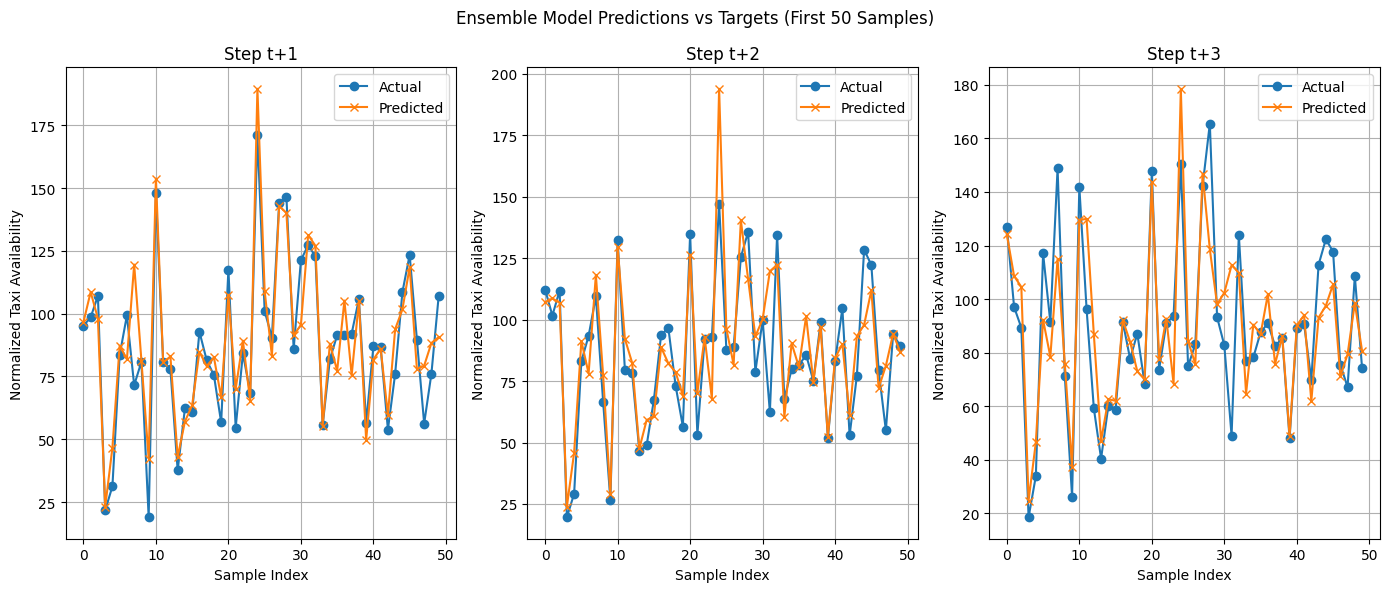

In [35]:
pred_rf = rf_model.predict(X_test_ens)
pred_xgb = xgb_model.predict(X_test_ens)
X_test_meta = np.hstack([pred_rf, pred_xgb])
ensemble_preds = meta_model.predict(X_test_meta)

# Convert to PyTorch tensors for consistent metric calculation
y_test_tensor = torch.tensor(y_test_ens, dtype=torch.float32)
y_pred_tensor = torch.tensor(ensemble_preds, dtype=torch.float32)

# Per-timestep MAE
mae_per_step = torch.mean(torch.abs(y_test_tensor - y_pred_tensor), dim=0)

# Average MAE across all steps
avg_mae = torch.mean(mae_per_step)

print(f"Average Ensemble MAE (all steps): {avg_mae:.4f}")
for i, mae_step in enumerate(mae_per_step):
    print(f"  ➤ Step t+{i+1} MAE: {mae_step:.4f}")

# Plot
plt.figure(figsize=(14, 6))
for t in range(3):  # for t+1, t+2, t+3
    plt.subplot(1, 3, t+1)
    plt.plot(y_test_ens[:50, t], label='Actual', marker='o')
    plt.plot(ensemble_preds[:50, t], label='Predicted', marker='x')
    plt.title(f"Step t+{t+1}")
    plt.xlabel("Sample Index")
    plt.ylabel("Normalized Taxi Availability")
    plt.legend()
    plt.grid(True)

plt.suptitle("Ensemble Model Predictions vs Targets (First 50 Samples)")
plt.tight_layout()
plt.show()
